In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import warnings
warnings.filterwarnings("ignore")
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from random import sample
from keras_preprocessing.image import ImageDataGenerator
from keras_applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

In [2]:
data_dir = "C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive"
all_xray_df = pd.read_csv(f'{data_dir}/Data_Entry_2017.csv')

# Fix columns and column names
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)
all_xray_df.rename(columns={'OriginalImage[Width': 'OriginalImageWidth', 'Height]': 'OriginalImageHeight', 'OriginalImagePixelSpacing[x': 'OriginalImagePixelSpacing_x', 'y]': 'OriginalImagePixelSpacing_y'}, inplace=True)

# Add path column to make retrieval easier
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_dir,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
31654,00008275_004.png,Atelectasis|Infiltration,4,8275,59,F,PA,2614,2991,0.143,0.143,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
23994,00006308_003.png,Mass,3,6308,54,M,PA,2048,2500,0.171,0.171,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...
17048,00004571_016.png,Nodule,16,4571,73,M,PA,2500,2048,0.168,0.168,C:/Code/AIHCND_C2/AIHCND_C2_Starter/archive\im...


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Split the diseases and comorbidities by the "Finding Labels" column, in order to have one column per disease as a binary value
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

# Add a binary value for each disease
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    tr_df, va_df = train_test_split(vargs, test_size=0.2, stratify=vargs['Pneumonia'])

    p_inds = tr_df[tr_df.Pneumonia==1].index.tolist()
    np_inds = tr_df[tr_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    tr_df = tr_df.loc[p_inds + np_sample]
    
    p_inds = va_df[va_df.Pneumonia==1].index.tolist()
    np_inds = va_df[va_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    va_df = va_df.loc[p_inds + np_sample]
    
    # Ensure we have equal distribution of positive and negative pneumonia cases in the training and testing sets
    print('Train:', tr_df.shape, 'Test:', va_df.shape)
    print('Train pneumonia:', tr_df['pneumonia_class'].sum() / tr_df.shape[0], 'Test pneumonia:', va_df['pneumonia_class'].sum() / va_df.shape[0])
    print('Train no pneumonia:', (tr_df.shape[0] - tr_df['pneumonia_class'].sum()) / tr_df.shape[0], 'Test no pneumonia:', (va_df.shape[0] - va_df['pneumonia_class'].sum()) / va_df.shape[0])
    print('Distribution of pneumonia classes in the training set:\n', tr_df['pneumonia_class'].value_counts())
    print('Distribution of pneumonia classes in the testing set:\n', va_df['pneumonia_class'].value_counts())
    
    # Check other distributions
    print('Distribution of genders in the training set:\n', tr_df['Patient Gender'].value_counts())
    print('Distribution of view positions in the training set:\n', tr_df['View Position'].value_counts())
    print('Mean age in the training set:\n', tr_df['Patient Age'].mean())
    print('Median age in the training set:\n', tr_df['Patient Age'].median())
    print('Mode age in the training set:\n', tr_df['Patient Age'].mode())
    
    print('Distribution of genders in the testing set:\n', va_df['Patient Gender'].value_counts())
    print('Distribution of view positions in the testing set:\n', va_df['View Position'].value_counts())
    print('Mean age in the testing set:\n', va_df['Patient Age'].mean())
    print('Median age in the testing set:\n', va_df['Patient Age'].median())
    print('Mode age in the testing set:\n', va_df['Patient Age'].mode())

    return tr_df, va_df

In [6]:
train_df, valid_df = create_splits(all_xray_df)

Train: (2290, 28) Test: (572, 28)
Train pneumonia: 0.5 Test pneumonia: 0.5
Train no pneumonia: 0.5 Test no pneumonia: 0.5
Distribution of pneumonia classes in the training set:
 pneumonia_class
1    1145
0    1145
Name: count, dtype: int64
Distribution of pneumonia classes in the testing set:
 pneumonia_class
1    286
0    286
Name: count, dtype: int64
Distribution of genders in the training set:
 Patient Gender
M    1346
F     944
Name: count, dtype: int64
Distribution of view positions in the training set:
 View Position
PA    1199
AP    1091
Name: count, dtype: int64
Mean age in the training set:
 45.68951965065502
Median age in the training set:
 48.0
Mode age in the training set:
 0    53
Name: Patient Age, dtype: int64
Distribution of genders in the testing set:
 Patient Gender
M    323
F    249
Name: count, dtype: int64
Distribution of view positions in the testing set:
 View Position
PA    312
AP    260
Name: count, dtype: int64
Mean age in the testing set:
 47.06818181818182
M

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                             horizontal_flip = True,
                             vertical_flip = False,
                             height_shift_range= 0.2,
                             width_shift_range=0.2,
                             rotation_range=20,
                             shear_range = 0.2,
                             zoom_range=0.1,
                             fill_mode = 'nearest',
                             )

    return my_idg

def make_train_gen(vargs):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    my_train_idg = my_image_augmentation(vargs)

    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs,
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'raw',
                                         target_size = (224, 224),
                                         batch_size = int(vargs.shape[0] / 16),
                                         shuffle = True,
                                         )

    return train_gen


def make_val_gen(vargs):
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    my_val_gen = my_val_idg.flow_from_dataframe(dataframe=valid_df,
                                          directory=None,
                                          x_col = 'path',
                                          y_col = 'Pneumonia',
                                          class_mode = 'raw',
                                          target_size = (224, 224),
                                          batch_size = int(vargs.shape[0] / 16)
                                         )    
    
    return my_val_gen

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(valid_df)
train_gen = make_train_gen(train_df)
valX, valY = val_gen.next()

Found 572 validated image filenames.
Found 2290 validated image filenames.


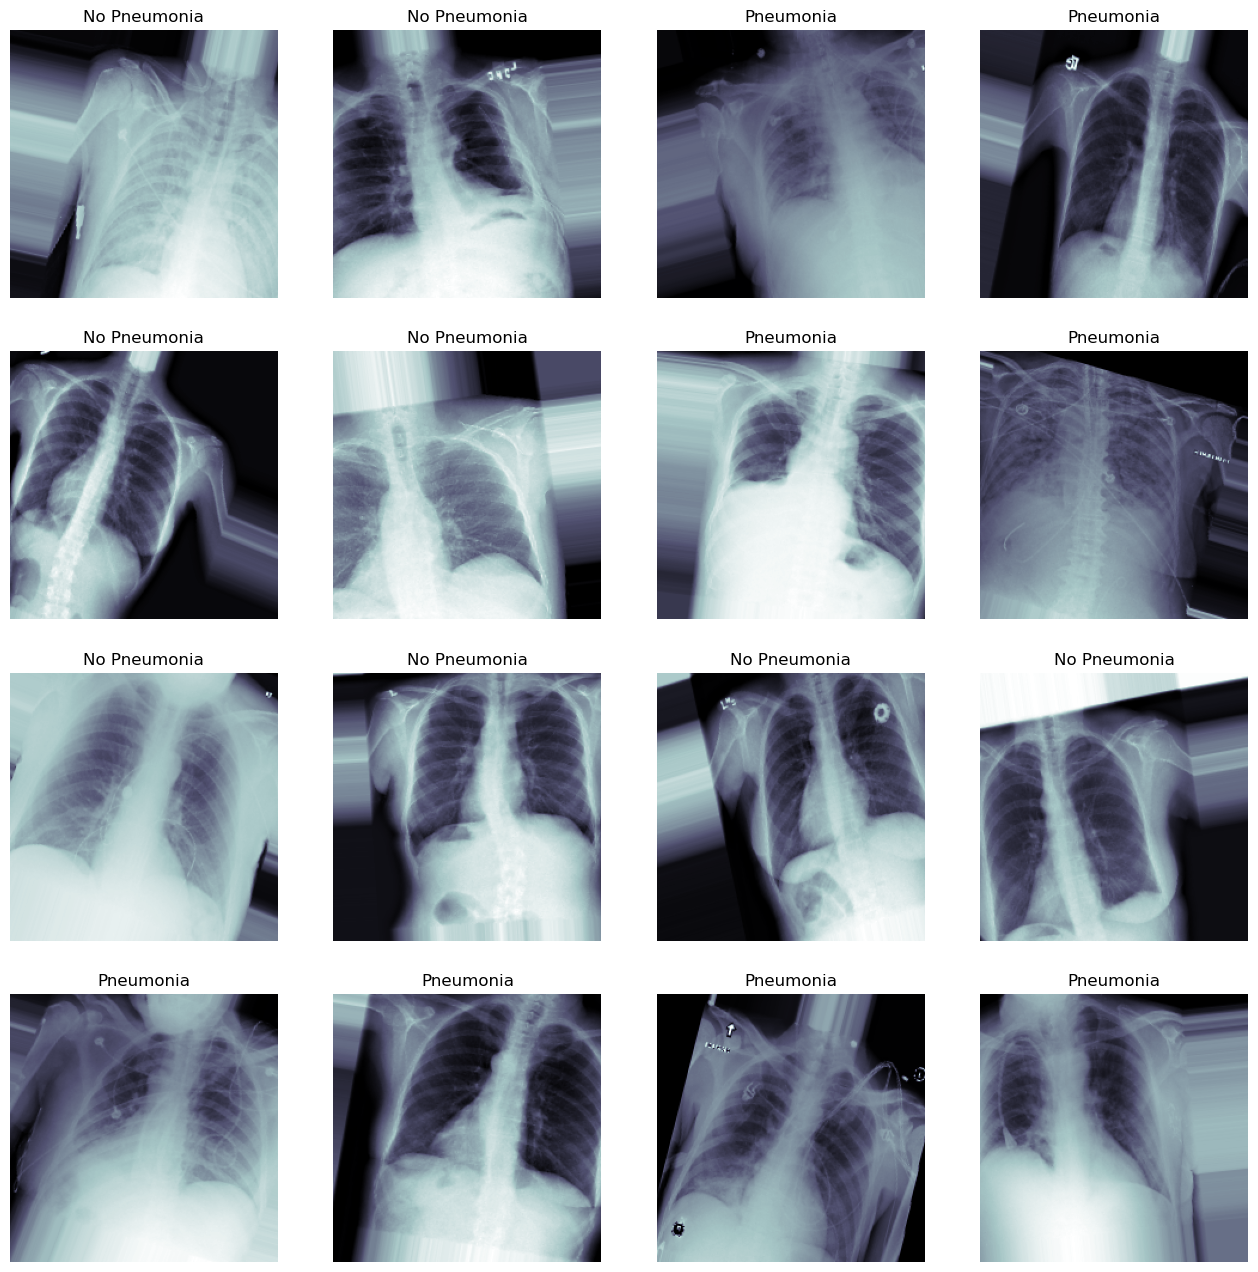

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model(vargs):
    model = VGG16(include_top=True, weights='imagenet')
    #model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                      outputs=transfer_layer.output)

    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    return vgg_model

#load_pretrained_model(train_df)

In [11]:
def build_my_model(vargs):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatten, Dense, Dropout, etc.)
    my_model.add(load_pretrained_model(vargs))
    my_model.add(Flatten())

    # Experiment with some other layers
    my_model.add(Dense(1024, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.005)))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.005)))

    my_model.add(Dense(len(all_labels), activation='sigmoid'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile

    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(learning_rate=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']    
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.weights.h5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

early = EarlyStopping(monitor='binary_accuracy', 
                      mode='max', 
                      patience=10,
                      restore_best_weights=True,
                      verbose=True)

callbacks_list = [checkpoint, early]

### Start training! 

In [13]:
## train your model
my_model = build_my_model(train_df)
history = my_model.fit(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 14.7064 - binary_accuracy: 0.4939
Epoch 1: binary_accuracy improved from -inf to 0.49389, saving model to xray_class_my_model.best.weights.h5
17/17 [==============================] - 54s 3s/step - loss: 14.7064 - binary_accuracy: 0.4939 - val_loss: 13.3284 - val_binary_accuracy: 0.4286
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 12.1897 - binary_accuracy: 0.5197
Epoch 2: binary_accuracy improved from 0.49389 to 0.51965, saving model to xray_class_my_model.best.weights.h5
17/17 [==============================] - 40s 2s/step - loss: 12.1897 - binary_accuracy: 0.5197 - val_loss: 11.1000 - val_binary_accuracy: 0.5714
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 10.2867 - binary_accuracy: 0.5668
Epoch 3: binary_accuracy improved from 0.51965 to 0.56681, saving model to xray_class_my_model.best.weights.h5
17/17 [==============================] - 41s 2s/step - loss: 10.2867 - 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [14]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

2/2 [==============================] - 0s 85ms/step


In [15]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, _ = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return

## what other performance statistics do you want to include here besides AUC? 

def print_confusion_matrix(vargs):
    cf = confusion_matrix(vargs['true'], vargs['pred'])
    print("Confusion matrix:")
    print(cf)

def print_class_report(vargs):
    cr = classification_report(vargs['true'], vargs['pred'])
    print("Classification report:")
    print(cr)

def plot_precision_recall_curve(t_y, p_y):
    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)

    # Plot the curve
    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot()
    plt.show()

def plot_precision_recall_f1(t_y, p_y):
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    
    # Calculate F1 score for each threshold
    f1_scores = []
    for threshold in thresholds:
        y_pred = (p_y >= threshold).astype(int)
        f1_scores.append(f1_score(t_y, y_pred))

    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label ='Recall')
    plt.plot(thresholds, f1_scores, label = 'F1 score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision / Recall / F1')
    plt.title("Precision / Recall / F1 and Thresholds")
    plt.legend(['Precision', 'Recall', 'F1 score'], loc='upper right')
    plt.show()

#Also consider plotting the history of your model training:

def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    
    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
    return

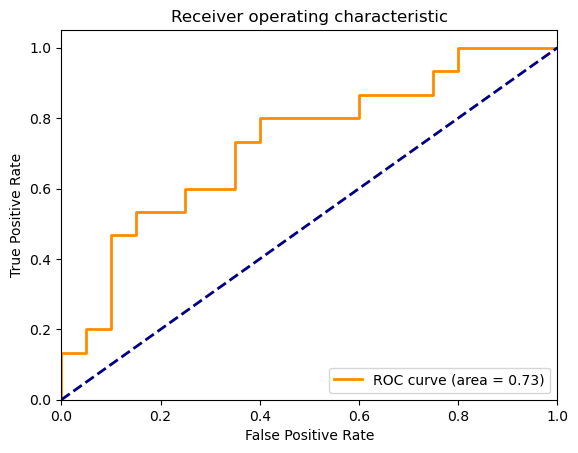

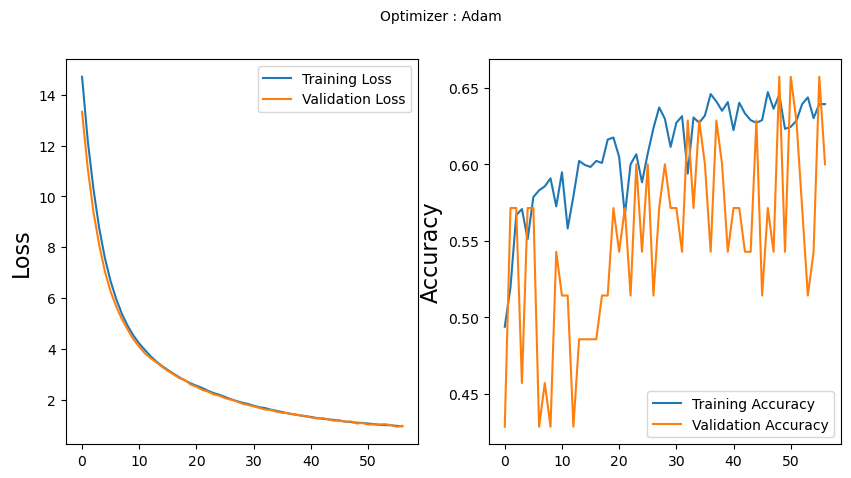

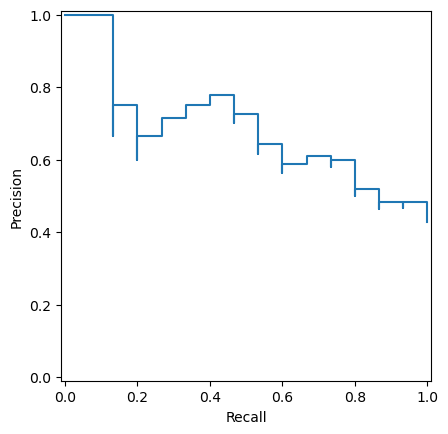

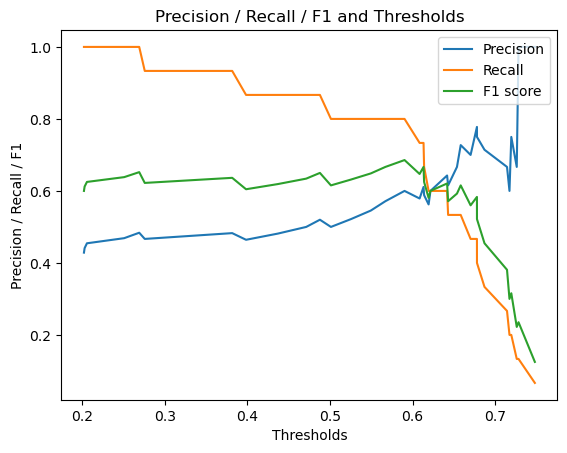

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.58      0.73      0.65        15

    accuracy                           0.66        35
   macro avg       0.66      0.67      0.66        35
weighted avg       0.68      0.66      0.66        35

Confusion matrix:
[[12  8]
 [ 4 11]]


In [23]:
## plot figures
threshold = 0.6
plot_auc(valY, pred_Y)
plot_history(history)
plot_precision_recall_curve(valY, pred_Y)
plot_precision_recall_f1(valY, pred_Y)
print_class_report({'true': valY, 'pred': pred_Y > threshold})
print_confusion_matrix({'true': valY, 'pred': pred_Y > threshold})


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [24]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
print_class_report({'true': valY, 'pred': pred_Y > threshold})
print_confusion_matrix({'true': valY, 'pred': pred_Y > threshold})
print('Accuracy:', accuracy_score(valY, pred_Y > threshold))
print('F1:', f1_score(valY, pred_Y > threshold))
print('Precision:', precision_score(valY, pred_Y > threshold))
print('Recall:', recall_score(valY, pred_Y > threshold))



Classification report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.58      0.73      0.65        15

    accuracy                           0.66        35
   macro avg       0.66      0.67      0.66        35
weighted avg       0.68      0.66      0.66        35

Confusion matrix:
[[12  8]
 [ 4 11]]
Accuracy: 0.6571428571428571
F1: 0.6470588235294118
Precision: 0.5789473684210527
Recall: 0.7333333333333333


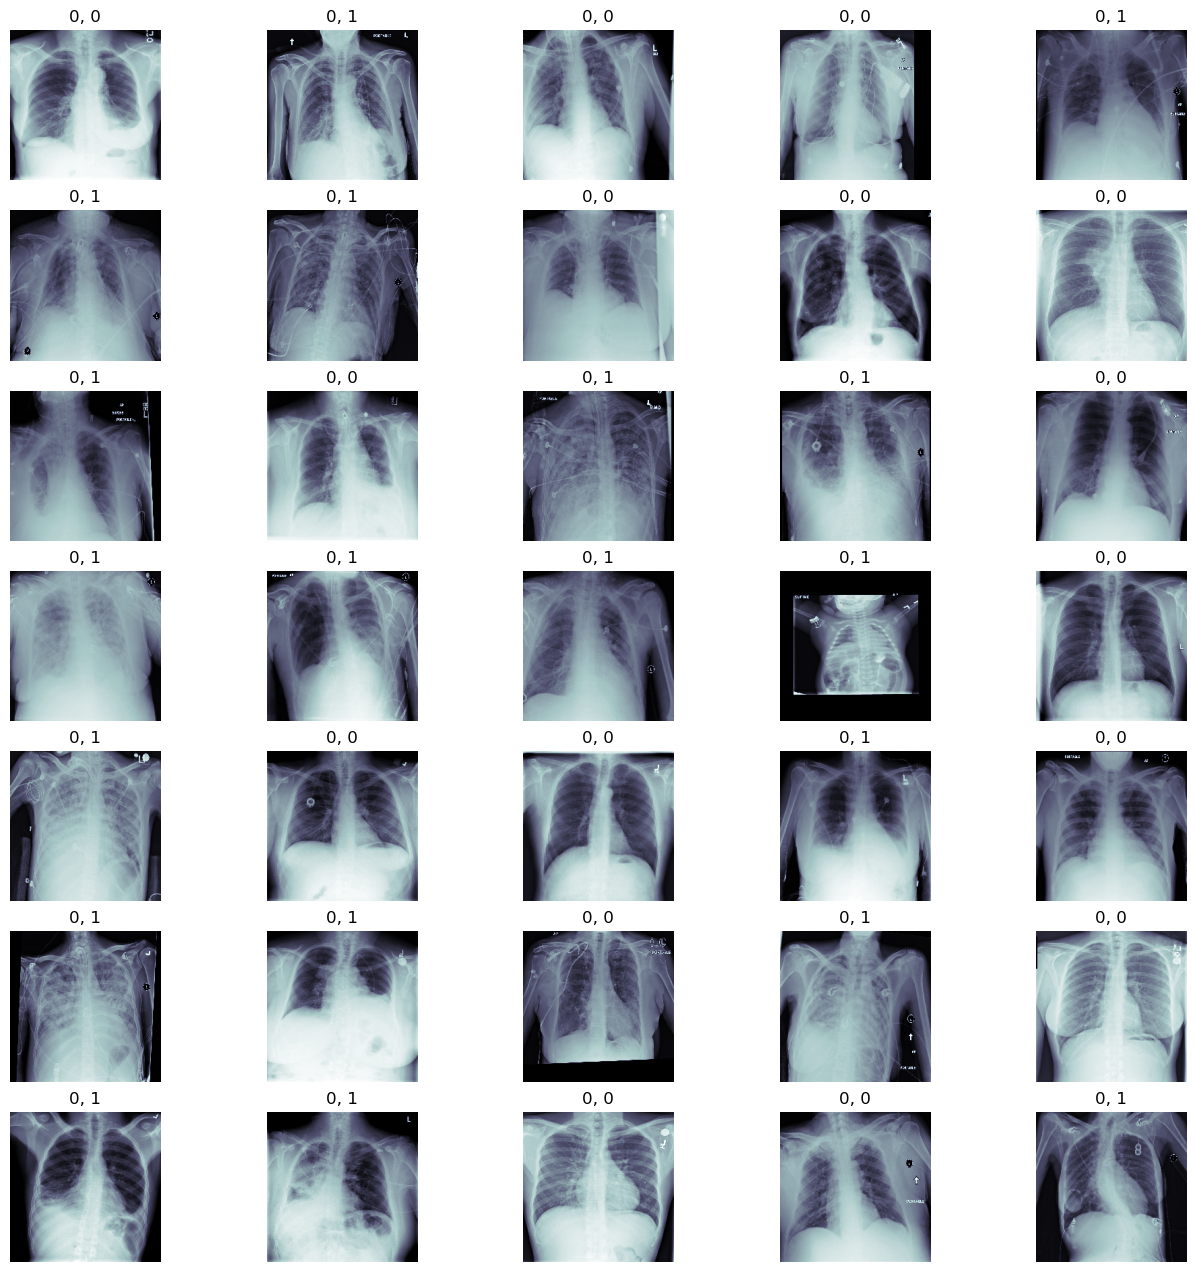

In [25]:
## Let's look at some examples of predicted v. true with our best model: 

fig, m_axs = plt.subplots(7, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i+=1

In [26]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)